Pipeline de l'étude, divisant la base de données en ensemble d'entraînement (afin d'entraîner les modèles) et en ensemble de test (sur lequel le modèle sera évalué).

In [1]:
import os 
import pandas as pd
import numpy as np

Creation des DB

In [2]:
# all file paths
from glob import glob
paths = glob(r"C:\Users\ahmed\MFE project\Final\**", recursive= True)

pathy = [i for i in paths if (len(i)>=120) & (i[-3:]!="pdf")]
pathy_amplicon = [i for i in pathy if i[-16:-8]=="amplicon"]

pathys = [i for i in paths if (i[-3:]!="pdf") & (len(i)>60) & (i.find("bcmatrix")<0)]
pathy_tsv = [i for i in pathys if i[-3:]=="tsv"]

In [3]:
#préparation du tsv

def extract_info_tsv(path):
    split = path.split('\\')
    annee = split[5]
    sp = split[6]
    spi = sp.replace('_', '-')
    spl = spi.split('-')
    type = 0
    date = 0
    num = 0
    if len(spl)==5:
        type = spl[0]
        date = '-'.join(spl[1:-1])
        num = spl[-1]
    if len(spl)==6:
        type = spl[0]
        date = spl[2]
        num = spl[-1]
    classe = split[7]
    return [annee, type, date, num, classe]

def create_TSV(pathy_tsv):
    caract = ["annee", "type", "date", "num", "classe"]
    df_list=[]
    for j in range(len(pathy_tsv)):
        path = pathy_tsv[j]
        dfa = pd.read_csv(path, sep='\t')
        if str(dfa["Barcode"][0])!="nan":
            df1 = dfa[dfa["Barcode"]==dfa["Barcode"][0]]
            df1.index = range(len(df1))
            cara = extract_info_tsv(path)
            for i in range(len(caract)):
                df1.loc[:,caract[i]]= cara[i]
            df1.loc[:,'ordre'] = j
            df1.loc[:,"longueur"] = len(df1)
            df_list.append(df1)
    df_tsv = pd.concat(df_list)
    df_tsv.index = range(len(df_tsv))
    df_tsv = df_tsv.replace("NAV", "NVA")
    df_tsv = df_tsv.replace("nva", "NVA")
    return df_tsv.fillna(0)
    

In [4]:
#preparation du amplicon
def extract_info_amplicon(path):
    split = path.split('\\')
    annee = split[5]
    sp = split[6]
    spi = sp.replace('_', '-')
    spl = spi.split('-')
    type = 0
    date = 0
    num = 0
    if len(spl)==5:
        type = spl[0]
        date = '-'.join(spl[1:-1])
        num = spl[-1]
    if len(spl)==6:
        type = spl[0]
        date = spl[2]
        num = spl[-1]
    classe = split[7]
    num2 = split[-1].split('_')[1]
    num3 = split[-1].split('_')[-1][:-17]
    return [annee, type, date, num, classe, num2, num3]

def create_amplicon(pathy_amplicon):
    caract = ["annee", "type", "date", "num", "classe", "num2", "num3"]
    df_list=[]
    for j in range(len(pathy_amplicon)):
        path = pathy_amplicon[j]
        df1 = pd.read_csv(path, sep='\t')
        cara = extract_info_amplicon(path)
        for i in range(len(caract)):
            df1.loc[:,caract[i]]= cara[i]
        df1.loc[:,'ordre'] = j
        df1.loc[:, "longueur"] = len(df1)
        df_list.append(df1)
    df_amplicon = pd.concat(df_list)
    df_amplicon.index = range(len(df_amplicon))
    df_amplicon = df_amplicon.replace("NAV", "NVA")
    df_amplicon = df_amplicon.replace("nva", "NVA")
    df_amplicon.loc[:, "contig_length"] = df_amplicon["contig_end"] - df_amplicon["contig_srt"]+1
    df_amplicon.loc[:, "gc_percent"] = df_amplicon["gc_count"]/df_amplicon["contig_length"]
    df_amplicon.loc[:, "cov20_percent"] = df_amplicon["cov20x"]/df_amplicon["contig_length"]
    df_amplicon.loc[:, "cov100_percent"] = df_amplicon["cov100x"]/df_amplicon["contig_length"]
    df_amplicon.loc[:, "cov500_percent"] = df_amplicon["cov500x"]/df_amplicon["contig_length"]
    df_amplicon.loc[:, "fwd_e2e_percent"] = df_amplicon["fwd_e2e"]/df_amplicon["fwd_reads"]
    df_amplicon.loc[:, "rev_e2e_percent"] = df_amplicon["rev_e2e"]/df_amplicon["rev_reads"]
    return df_amplicon.fillna(0)

In [87]:
#pour avoir une df avec les infos et les ordres. afin de pouvoir bien les séparer pour le k-fold.
def get_df_info_amplicon(pathy_amplicon):
    df_list=[]
    for j in range(len(pathy_amplicon)):
        info = extract_info_amplicon(pathy_amplicon[j])
        info.append(j)
        df_info = pd.DataFrame([info], columns=["annee", "type", "date", "num", "classe", "num2", "num3", "ordre"])
        df_list.append(df_info)
    df_am = pd.concat(df_list)
    df_am.index = range(len(df_am))
    df_am = df_am.replace("NAV", "NVA")
    df_am = df_am.replace("nva", "NVA")
    return df_am
    

In [77]:
#vérifier si un type de cancer a une distribution différentes des autres en terme de qualité.
#nombres/type: 186, 108, 230, 21, 41, 12
liste = ["CVC", "OBL", "NDN", "TM", "BAL", "BM"]
lis = []
for li in liste:
    k = []
    ok = df_am[df_am["type"]==li]
    k.append(len(ok[ok["classe"]=="OPT"])/len(ok))
    k.append(len(ok[ok["classe"]=="NC"])/len(ok))
    k.append(len(ok[ok["classe"]=="SOPT"])/len(ok))
    k.append(len(ok[ok["classe"]=="NVA"])/len(ok))
    lis.append(k)
df_lis = pd.DataFrame(lis, columns=["OPT", "NC", "SOPT", "NVA"], index=liste)

df_lis

In [5]:
DF_tsv = create_TSV(pathy_tsv)
DF_amplicon = create_amplicon(pathy_amplicon)

C:\Users\ahmed\anaconda3\envs\myenv\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [90]:
# VRAI K-FOLD

#pipelining intégrant le kfold
from sklearn.model_selection import StratifiedKFold
def create_df_kfold(df, df_am, carac):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    index_train = []
    index_test = []
    for train_index, test_index in skf.split(df_am["ordre"], df_am[carac]):
        index_train.append(train_index)
        index_test.append(test_index)
    return index_train, index_test

def split_amplicon_train_test(df, index_train, index_test):
    df_train = pd.concat([df[df["ordre"]==i] for i in index_train])
    df_train.index = range(len(df_train))

    df_test = pd.concat([df[df["ordre"]==i] for i in index_test])
    df_test.index = range(len(df_test))
    return df_train, df_test

#normaliser le train puis l'appliquer au test
from sklearn.preprocessing import MinMaxScaler
def norm_split_tsv_train_test(df_tsv, lis_train, lis_test):
    scaler = MinMaxScaler()
    train = pd.concat([df_tsv[df_tsv["ordre"]==i] for i in lis_train])
    train.index = range(len(train))
    test = pd.concat([df_tsv[df_tsv["ordre"]==i] for i in lis_test])
    test.index = range(len(test))
    train_norm = scaler.fit_transform(train[["Frequency", "Quality", "Coverage", "Allele Cov", "longueur"]])
    train_norm = pd.concat([train, pd.DataFrame(train_norm, columns = ["Frequency_norm", "Quality_norm", "Coverage_norm", "Allele Cov_norm", "longueur_norm"])], axis = 1)
    test_norm = scaler.transform(test[["Frequency", "Quality", "Coverage", "Allele Cov", "longueur"]])
    test_norm = pd.concat([test, pd.DataFrame(test_norm, columns = ["Frequency_norm", "Quality_norm", "Coverage_norm", "Allele Cov_norm", "longueur_norm"])], axis = 1)
    return train_norm, test_norm

def pred2class(df_train, df_test, clf):
    New_var1 = ['gc_percent', 'cov500_percent', 'fwd_e2e_percent', 'rev_e2e_percent', 'cov20_percent', 'cov100_percent', 'contig_length']
    train_2class = df_train[(df_train["classe"]=="OPT")|(df_train["classe"]=="NC")]
    clf.fit(train_2class[New_var1], train_2class["classe"])
    pred_train = clf.predict(df_train[New_var1])
    pred_test = clf.predict(df_test[New_var1])
    df_train.loc[:,"pred2class"] = pred_train
    df_test.loc[:,"pred2class"] = pred_test
    return df_train, df_test

def train_test_amp_tsv(df_amp, df_tsv, lis_train, lis_test, clf):
    train, test = split_amplicon_train_test(df_amp, lis_train, lis_test)
    tsv_train_norm, tsv_test_norm = norm_split_tsv_train_test(df_tsv, lis_train, lis_test)
    df_amp_train, df_amp_test = pred2class(train, test, clf)
    return df_amp_train, df_amp_test, tsv_train_norm, tsv_test_norm
    

on normalise et ajoute des features. On sépare aussi le test et train set

In [6]:
# en prenant au hasard -----> FAUX K-FOLD

# split dataframe into one train sample and one test sample
from sklearn.model_selection import train_test_split
def split_df_test_train(df, carac, percent):
    if carac == "type":
        liste = ["CVC", "OBL", "NDN", "TM", "BAL", "BM"]
    if carac == "classe":
        liste = ["OPT", "NC", "SOPT", "NVA"]
    ordre_train= []
    ordre_test=[]
    for i in liste:
        df_typ = df[df[carac]==i]
        lis = list(dict.fromkeys(df_typ["ordre"].values))
        lis_train, lis_test = train_test_split(lis, test_size=percent, shuffle = True)
        ordre_train.extend(lis_train)
        ordre_test.extend(lis_test)

    df_train = pd.concat([df[df["ordre"]==i] for i in ordre_train])
    df_train.index = range(len(df_train))

    df_test = pd.concat([df[df["ordre"]==i] for i in ordre_test])
    df_test.index = range(len(df_test))

    return df_train, df_test, ordre_train, ordre_test

#normaliser le train puis l'appliquer au test
from sklearn.preprocessing import MinMaxScaler
# def norm_split_tsv_train_test(df_tsv, lis_train, lis_test):
#     scaler = MinMaxScaler()
#     train = pd.concat([df_tsv[df_tsv["ordre"]==i] for i in lis_train])
#     train.index = range(len(train))
#     test = pd.concat([df_tsv[df_tsv["ordre"]==i] for i in lis_test])
#     test.index = range(len(test))
#     train_norm = scaler.fit_transform(train[["Frequency", "Quality", "Coverage", "Allele Cov", "longueur"]])
#     train_norm = pd.concat([train, pd.DataFrame(train_norm, columns = ["Frequency_norm", "Quality_norm", "Coverage_norm", "Allele Cov_norm", "longueur_norm"])], axis = 1)
#     test_norm = scaler.transform(test[["Frequency", "Quality", "Coverage", "Allele Cov", "longueur"]])
#     test_norm = pd.concat([test, pd.DataFrame(test_norm, columns = ["Frequency_norm", "Quality_norm", "Coverage_norm", "Allele Cov_norm", "longueur_norm"])], axis = 1)
#     return train_norm, test_norm

# def pred2class(df_train, df_test, clf):
#     New_var1 = ['gc_percent', 'cov500_percent', 'fwd_e2e_percent', 'rev_e2e_percent', 'cov20_percent', 'cov100_percent', 'contig_length']
#     train_2class = df_train[(df_train["classe"]=="OPT")|(df_train["classe"]=="NC")]
#     clf.fit(train_2class[New_var1], train_2class["classe"])
#     pred_train = clf.predict(df_train[New_var1])
#     pred_test = clf.predict(df_test[New_var1])
#     df_train.loc[:,"pred2class"] = pred_train
#     df_test.loc[:,"pred2class"] = pred_test
#     return df_train, df_test

# def train_test_amp_tsv(df_amp, df_tsv, carac, percent, clf):
#     train, test, lis_train, lis_test = split_df_test_train(df_amp, carac, percent)
#     tsv_train_norm, tsv_test_norm = norm_split_tsv_train_test(df_tsv, lis_train, lis_test)
#     df_amp_train, df_amp_test = pred2class(train, test, clf)
#     return df_amp_train, df_amp_test, tsv_train_norm, tsv_test_norm


In [276]:
# prédiction 2 classes, en local
# from sklearn.tree import DecisionTreeClassifier
# clf =DecisionTreeClassifier(min_samples_leaf=17,max_depth= 10, min_samples_split= 9)

# df_amp_train, df_amp_test, df_tsv_train, df_tsv_test = train_test_amp_tsv(DF_amplicon, DF_tsv, "type", 0.3, clf2)

les fichiers locaux et leurs variables locales sont faites (tsv normé, 6 nouvelles features pour amplicon + la prédiction 2 classes).

Passons maintenant aux variables globales

In [92]:
# des fonctions pour extraire les variables globales
def Extract_glob_feat(df, feat, longueur):
    nume = []
    nume.append(np.array([1 for i in df[feat].values if i>0.3]).sum()/longueur)
    nume.append(np.array([1 for i in df[feat].values if i>0.5]).sum()/longueur)
    nume.append(np.array([1 for i in df[feat].values if i>0.7]).sum()/longueur)
    nume.append(np.array([1 for i in df[feat].values if i>0.9]).sum()/longueur)
    df_res = pd.DataFrame(data = [[df[feat].mean(), df[feat].median(), nume[0], nume[1], nume[2], nume[3]]] , columns = [feat+"_mean", feat+"_median", feat+"_"+str(0.3), feat+"_"+str(0.5), feat+"_"+str(0.7), feat+"_"+str(0.9)])
    return df_res
    
def extract_all_var(df, variables, longueur):
    list_df = []
    for feat in variables:
        df_t = Extract_glob_feat(df, feat, longueur)
        list_df.append(df_t)
    df_tot = pd.concat(list_df, axis = 1)
    return df_tot

def create_var_glob_amplicon(df_amp):
    var_percent = ['gc_percent', 'cov20_percent', 'cov100_percent', 'cov500_percent', 'fwd_e2e_percent', 'rev_e2e_percent']
    ordr = list(dict.fromkeys(df_amp["ordre"].values))
    resultat = []

    for i in ordr:
        df_tru = df_amp[df_amp["ordre"]==i]
        longueur = df_tru["longueur"].values[0]
    # information des variables en pourcent
        df_var = extract_all_var(df_tru, var_percent, longueur)

    # information sur la classe
        df_var.loc[:,"ordre"] = i
        df_var.loc[:, "type"] = df_tru["type"].values[0]
        df_var.loc[:, "date"] = df_tru["date"].values[0]
        df_var.loc[:, "classe"] = df_tru["classe"].values[0]
        df_var.loc[:, "num2"] = df_tru["num2"].values[0]
        df_var.loc[:, "longueur"] = longueur

    # varible globale % de OPT
        OPT = np.array([1 for i in range(len(df_tru)) if df_tru["pred2class"].values[i]=="OPT"]).sum()
        OPT_percent = OPT/longueur

        df_var.loc[:, "OPT_percent"] = OPT_percent

    # création de la base de données / CSV
        resultat.append(df_var)
    df_resul = pd.concat(resultat)
    df_resul.index = range(len(df_resul))
    return df_resul

def create_var_glob_tsv(df_tsv):
    var_percent = ['Frequency_norm', 'Quality_norm', 'Coverage_norm', 'Allele Cov_norm', 'longueur_norm']
    ordr = list(dict.fromkeys(df_tsv["ordre"].values))
    resultat = []

    for i in ordr:
        df_tru = df_tsv[df_tsv["ordre"]==i]
        longueur = df_tru["longueur"].values[0]
# information des variables en pourcent
        df_var = extract_all_var(df_tru, var_percent, longueur)

# création de la base de données / CSV
        resultat.append(df_var)
    df_resul = pd.concat(resultat)
    df_resul.index = range(len(df_resul))
    return df_resul

def create_var_glob_tot(df_amp, df_tsv):
    df_amp_glob = create_var_glob_amplicon(df_amp)
    df_tsv_glob = create_var_glob_tsv(df_tsv)
    df_global = pd.concat([df_amp_glob, df_tsv_glob], axis = 1)
    return df_global

In [ ]:
# train = create_var_glob_tot(df_amp_train, df_tsv_train)
# test = create_var_glob_tot(df_amp_test, df_tsv_test)

In [94]:
def select_features(liste):
    if liste == "all":
        features = ['gc_percent_mean', 'gc_percent_median',
       'gc_percent_0.3', 'gc_percent_0.5', 'gc_percent_0.7', 'gc_percent_0.9',
       'cov20_percent_mean', 'cov20_percent_median', 'cov20_percent_0.3',
       'cov20_percent_0.5', 'cov20_percent_0.7', 'cov20_percent_0.9',
       'cov100_percent_mean', 'cov100_percent_median', 'cov100_percent_0.3',
       'cov100_percent_0.5', 'cov100_percent_0.7', 'cov100_percent_0.9',
       'cov500_percent_mean', 'cov500_percent_median', 'cov500_percent_0.3',
       'cov500_percent_0.5', 'cov500_percent_0.7', 'cov500_percent_0.9',
       'fwd_e2e_percent_mean', 'fwd_e2e_percent_median', 'fwd_e2e_percent_0.3',
       'fwd_e2e_percent_0.5', 'fwd_e2e_percent_0.7', 'fwd_e2e_percent_0.9',
       'rev_e2e_percent_mean', 'rev_e2e_percent_median', 'rev_e2e_percent_0.3',
       'rev_e2e_percent_0.5', 'rev_e2e_percent_0.7', 'rev_e2e_percent_0.9', 'longueur', 'OPT_percent',
       'Frequency_norm_mean', 'Frequency_norm_median', 'Frequency_norm_0.3',
       'Frequency_norm_0.5', 'Frequency_norm_0.7', 'Frequency_norm_0.9',
       'Quality_norm_mean', 'Quality_norm_median', 'Quality_norm_0.3',
       'Quality_norm_0.5', 'Quality_norm_0.7', 'Quality_norm_0.9',
       'Coverage_norm_mean', 'Coverage_norm_median', 'Coverage_norm_0.3',
       'Coverage_norm_0.5', 'Coverage_norm_0.7', 'Coverage_norm_0.9',
       'Allele Cov_norm_mean', 'Allele Cov_norm_median', 'Allele Cov_norm_0.3',
       'Allele Cov_norm_0.5', 'Allele Cov_norm_0.7', 'Allele Cov_norm_0.9',
       'longueur_norm_mean', 'longueur_norm_median', 'longueur_norm_0.3',
       'longueur_norm_0.5', 'longueur_norm_0.7', 'longueur_norm_0.9']

    elif liste == "amplicon":
        features = ['gc_percent_mean', 'gc_percent_median',
       'gc_percent_0.3', 'gc_percent_0.5', 'gc_percent_0.7', 'gc_percent_0.9',
       'cov20_percent_mean', 'cov20_percent_median', 'cov20_percent_0.3',
       'cov20_percent_0.5', 'cov20_percent_0.7', 'cov20_percent_0.9',
       'cov100_percent_mean', 'cov100_percent_median', 'cov100_percent_0.3',
       'cov100_percent_0.5', 'cov100_percent_0.7', 'cov100_percent_0.9',
       'cov500_percent_mean', 'cov500_percent_median', 'cov500_percent_0.3',
       'cov500_percent_0.5', 'cov500_percent_0.7', 'cov500_percent_0.9',
       'fwd_e2e_percent_mean', 'fwd_e2e_percent_median', 'fwd_e2e_percent_0.3',
       'fwd_e2e_percent_0.5', 'fwd_e2e_percent_0.7', 'fwd_e2e_percent_0.9',
       'rev_e2e_percent_mean', 'rev_e2e_percent_median', 'rev_e2e_percent_0.3',
       'rev_e2e_percent_0.5', 'rev_e2e_percent_0.7', 'rev_e2e_percent_0.9', 'longueur', 'OPT_percent']
    
    elif liste == "tsv":
        features = ['Frequency_norm_mean', 'Frequency_norm_median', 'Frequency_norm_0.3',
       'Frequency_norm_0.5', 'Frequency_norm_0.7', 'Frequency_norm_0.9',
       'Quality_norm_mean', 'Quality_norm_median', 'Quality_norm_0.3',
       'Quality_norm_0.5', 'Quality_norm_0.7', 'Quality_norm_0.9',
       'Coverage_norm_mean', 'Coverage_norm_median', 'Coverage_norm_0.3',
       'Coverage_norm_0.5', 'Coverage_norm_0.7', 'Coverage_norm_0.9',
       'Allele Cov_norm_mean', 'Allele Cov_norm_median', 'Allele Cov_norm_0.3',
       'Allele Cov_norm_0.5', 'Allele Cov_norm_0.7', 'Allele Cov_norm_0.9',
       'longueur_norm_mean', 'longueur_norm_median', 'longueur_norm_0.3',
       'longueur_norm_0.5', 'longueur_norm_0.7', 'longueur_norm_0.9']

    elif liste == "Pearson":
        features = ['gc_percent_mean', 'gc_percent_0.7',
       'cov20_percent_mean', 'cov20_percent_median', 'cov100_percent_mean',
       'fwd_e2e_percent_mean', 'fwd_e2e_percent_median', 'fwd_e2e_percent_0.3',
       'fwd_e2e_percent_0.9', 'OPT_percent', 'longueur',
       'Frequency_norm_mean', 'Frequency_norm_0.7',
       'Quality_norm_mean', 'Quality_norm_0.7', 'Quality_norm_0.9',
       'Coverage_norm_mean','Coverage_norm_0.9',
       'longueur_norm_mean', 'longueur_norm_0.3',
       'longueur_norm_0.5', 'longueur_norm_0.7']

    elif liste == "Spearman":
        features = ['gc_percent_mean',
       'gc_percent_0.3', 'gc_percent_0.5', 'gc_percent_0.9',
       'cov20_percent_mean', 'cov20_percent_median', 'cov100_percent_mean', 'cov100_percent_median',
       'cov500_percent_median', 'fwd_e2e_percent_mean', 'fwd_e2e_percent_median', 'fwd_e2e_percent_0.3',
       'fwd_e2e_percent_0.5', 'fwd_e2e_percent_0.7', 'fwd_e2e_percent_0.9',
       'rev_e2e_percent_mean', 'rev_e2e_percent_0.3',
       'rev_e2e_percent_0.5', 'rev_e2e_percent_0.7', 'rev_e2e_percent_0.9', 'longueur', 'OPT_percent',
       'Frequency_norm_mean', 'Frequency_norm_0.3',
       'Quality_norm_mean',
       'Quality_norm_0.5', 'Quality_norm_0.7', 'Quality_norm_0.9',
       'Coverage_norm_mean',
       'longueur_norm_mean', 'longueur_norm_0.3',
       'longueur_norm_0.5', 'longueur_norm_0.7', 'longueur_norm_0.9']
    
    elif liste == "rfe":
        features = ['cov100_percent_0.9', 'cov500_percent_mean', 'cov500_percent_0.3',
       'cov500_percent_0.5', 'cov500_percent_0.7', 'cov500_percent_0.9',
       'OPT_percent', 'Frequency_norm_mean', 'Frequency_norm_median',
       'Frequency_norm_0.3', 'Frequency_norm_0.5', 'Quality_norm_mean',
       'Quality_norm_median', 'Quality_norm_0.3', 'Coverage_norm_mean',
       'Coverage_norm_median', 'Coverage_norm_0.3', 'Coverage_norm_0.5',
       'Coverage_norm_0.7', 'Coverage_norm_0.9', 'Allele Cov_norm_mean',
       'Allele Cov_norm_median', 'Allele Cov_norm_0.9',
       'longueur_norm_mean', 'longueur_norm_median']

    elif liste == "rf":
        features = ['cov100_percent_mean', 'Coverage_norm_0.9', 'Frequency_norm_median',
       'Coverage_norm_0.7', 'cov500_percent_median', 'Quality_norm_mean',
       'Quality_norm_0.3', 'Allele Cov_norm_0.3', 'Coverage_norm_0.3',
       'Frequency_norm_mean', 'longueur_norm_median', 'Coverage_norm_0.5',
       'Frequency_norm_0.3', 'cov500_percent_0.9', 'cov500_percent_mean',
       'longueur_norm_mean', 'Allele Cov_norm_mean', 'Coverage_norm_median',
       'Coverage_norm_mean', 'cov500_percent_0.5', 'cov500_percent_0.7',
       'Quality_norm_median', 'Allele Cov_norm_median', 'cov500_percent_0.3',
       'OPT_percent']

    return features

#RFE
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import RFE
# estim = RandomForestClassifier(n_estimators=50)
# rfe = RFE(estim, n_features_to_select=25, step=1)
# rfe = rfe.fit(train[select_features("all")], train["classe"])
# feat_imp = pd.concat([pd.DataFrame(rfe.support_, columns=["imp"]),pd.DataFrame(select_features("all"), columns=["feat"])], axis=1)
# feat_rfe = feat_imp[feat_imp["imp"]==True]["feat"].values
# feat_rfe

#RF
# feat_imprf = pd.DataFrame(clf.feature_importances_, index=select_features("all"))
# feat_imprf.sort_values(0)[-25:].index

In [95]:
def F1score(mat):
    res = []
    for i in range(len(mat)):
        precision = mat[i][i]/np.sum([j[i] for j in mat])
        recall = mat[i][i]/np.sum(mat[i])
        F1 = (2 * precision * recall)/(precision + recall)
        res.append(F1)
    return res

from sklearn.metrics import f1_score

from statsmodels.stats.contingency_tables import mcnemar

def macnemar(preda, predb, groundtruth):
    Ta = preda==groundtruth
    Tb = predb==groundtruth

    a = ((Ta==True)*(Tb==True)).sum()
    b = ((Ta==True)*(Tb==False)).sum()
    c = ((Ta==False)*(Tb==True)).sum()
    d = ((Ta==False)*(Tb==False)).sum()

    ct = [[a,b], [c,d]]

    m = mcnemar(ct, exact=True)
    print(m)

In [97]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators= 50)

def get_pred(train, test, clf):
    feats = ["all", "amplicon", "tsv", "Pearson", "Spearman", "rfe", "rf"]
    resu = []
    for feat in feats:
        clf.fit(train[select_features(feat)], train["classe"])
        pred = pd.DataFrame(clf.predict(test[select_features(feat)]), columns=["pred_"+feat])
        resu.append(pred)
    resus = pd.concat(resu, axis=1)
    resus.loc[:, "classe"] = test["classe"]
    return resus

# def k_fold(DF_amplicon, DF_tsv, DT, clf, num):
#     resultats = []
#     for nu in range(num):
#         df_amp_train, df_amp_test, df_tsv_train, df_tsv_test = train_test_amp_tsv(DF_amplicon, DF_tsv, "classe", 0.3, DT)

#         #création des databases finales
#         train = create_var_glob_tot(df_amp_train, df_tsv_train)
#         test = create_var_glob_tot(df_amp_test, df_tsv_test)
#         pre = get_pred(train, test, clf)                           méthode inappropriée
#         pre.loc[:, "num"]=nu
#         resultats.append(pre)
#     res = pd.concat(resultats)
#     res.index = range(len(res))
#     return res

# def get_metrics(pre):
#     res_f1 = []
#     res_F1n = []
#     results =[]
#     for num in range(pre["num"].values[-1]+1):
        
#         pred = pre[pre["num"]==num]
#         columns = pred.columns[:-2]
#         for feat in columns:
#             mat = confusion_matrix(pred["classe"], pred[feat], normalize="true", labels=["OPT", "NC", "SOPT", "NVA"])
#             F1 = F1score(mat)
#             df_F1 = pd.DataFrame(np.array(F1).T, columns=[feat])
            
#             res_f1.append(df_F1)
#         res_F1n = pd.concat(res_f1, axis=1)
#         res_F1n.loc[:,"num"]=num
#         res_F1n.loc[:,"classe"] = ["OPT", "NC", "SOPT", "NVA"]
#         results.append(res_F1n)
#     print(results[0])
#     df_metrics = pd.concat(results, ignore_index=True)
#     df_metrics.index = range(len(df_metrics))
#     return df_metrics

In [96]:
# prédiction 2 classes, en local
from sklearn.tree import DecisionTreeClassifier
DT =DecisionTreeClassifier(min_samples_leaf=17,max_depth= 10, min_samples_split= 9)

df_amp_train, df_amp_test, df_tsv_train, df_tsv_test = train_test_amp_tsv(DF_amplicon, DF_tsv, "classe", 0.3, DT)

#création des databases finales
train = create_var_glob_tot(df_amp_train, df_tsv_train)
test = create_var_glob_tot(df_amp_test, df_tsv_test)

In [153]:
index_train, index_test = create_df_kfold(DF_amplicon, df_am, "type")
from sklearn.tree import DecisionTreeClassifier
clf1 =DecisionTreeClassifier(min_samples_leaf=17,max_depth= 10, min_samples_split= 9)
from sklearn.ensemble import RandomForestClassifier
# clf2 = RandomForestClassifier(n_estimators= 50)
clf2 =DecisionTreeClassifier(min_samples_leaf=17,max_depth= 10, min_samples_split= 9)

def get_results(DF_amplicon, DF_tsv, index_train, index_test, clf1, clf2):
    résultats = []
    for i in range(5):
        train_index = index_train[i]
        test_index = index_test[i]
        df_amp_train, df_amp_test, df_tsv_train, df_tsv_test = train_test_amp_tsv(DF_amplicon, DF_tsv, train_index, test_index, clf1)
        train = create_var_glob_tot(df_amp_train, df_tsv_train)
        test = create_var_glob_tot(df_amp_test, df_tsv_test)
        pre = get_pred(train, test, clf2)
        pre.loc[:,"fold"] = i
        résultats.append(pre)
    res = pd.concat(résultats)
    res.index = range(len(res))
    return res


In [154]:
resul2 = get_results(DF_amplicon, DF_tsv, index_train, index_test, clf1, clf2)

In [143]:
len(resul[resul["fold"]==0])

120

In [108]:
resul[["pred_all", "pred_amplicon", "pred_tsv", "pred_Pearson", "pred_Spearman", "pred_rfe", "pred_rf"]]

,pred_all,pred_amplicon,pred_tsv,pred_Pearson,pred_Spearman,pred_rfe,pred_rf
0,SOPT,SOPT,SOPT,SOPT,SOPT,SOPT,SOPT
1,SOPT,SOPT,SOPT,SOPT,SOPT,SOPT,SOPT
2,NC,NC,NC,NC,NC,NC,NC
3,OPT,OPT,OPT,OPT,OPT,OPT,OPT
4,OPT,OPT,OPT,OPT,OPT,OPT,OPT
...,...,...,...,...,...,...,...
593,OPT,OPT,OPT,OPT,OPT,OPT,OPT
594,SOPT,SOPT,SOPT,SOPT,SOPT,SOPT,SOPT
595,NVA,SOPT,NVA,NVA,NVA,NVA,NVA
596,NC,NC,NC,NC,NC,NC,NC


In [133]:
macnemar(resul2["pred_rfe"], resul2["pred_all"], resul2["classe"])

pvalue      0.057373046875
statistic   3.0


In [155]:
from sklearn.metrics import confusion_matrix
confusion_matrix(resul2["classe"], resul2["pred_all"], normalize="true", labels=["OPT", "NC", "SOPT", "NVA"])

array([[0.95373665, 0.        , 0.03914591, 0.00711744],
       [0.        , 0.93975904, 0.06024096, 0.        ],
       [0.09493671, 0.08227848, 0.74050633, 0.08227848],
       [0.02631579, 0.        , 0.02631579, 0.94736842]])

In [159]:
confusion_matrix(resul2["classe"], resul2["pred_all"], normalize="pred", labels=["OPT", "NC", "SOPT", "NVA"])

array([[0.94035088, 0.        , 0.08148148, 0.02298851],
       [0.        , 0.85714286, 0.03703704, 0.        ],
       [0.05263158, 0.14285714, 0.86666667, 0.14942529],
       [0.00701754, 0.        , 0.01481481, 0.82758621]])

In [158]:
confusion_matrix(resul["classe"], resul["pred_all"], normalize="pred", labels=["OPT", "NC", "SOPT", "NVA"])

array([[0.97841727, 0.        , 0.05625   , 0.        ],
       [0.        , 0.90804598, 0.025     , 0.        ],
       [0.01438849, 0.09195402, 0.90625   , 0.01369863],
       [0.00719424, 0.        , 0.0125    , 0.98630137]])

In [139]:
resul[(resul["classe"]=="NVA") & (resul["pred_all"]=="OPT")]

,pred_all,pred_amplicon,pred_tsv,pred_Pearson,pred_Spearman,pred_rfe,pred_rf,classe,fold
89,OPT,OPT,OPT,NVA,OPT,OPT,OPT,NVA,0
117,OPT,OPT,OPT,OPT,OPT,NVA,OPT,NVA,0


In [148]:
ordre = index_test
ordre[0][117]

581

In [166]:
import itertools
ordre_col = list(itertools.chain.from_iterable(ordre))

In [168]:
df_resu = resul
df_resu.loc[:,"ordre1"]=ordre_col

In [171]:
df_resu = df_resu.sort_values("ordre1")
df_resu.index = range(len(df_resu))
df_resu

,pred_all,pred_amplicon,pred_tsv,pred_Pearson,pred_Spearman,pred_rfe,pred_rf,classe,fold,ordre1
0,OPT,OPT,OPT,OPT,OPT,OPT,OPT,OPT,2,0
1,OPT,OPT,SOPT,OPT,OPT,OPT,OPT,OPT,1,1
2,SOPT,SOPT,SOPT,SOPT,SOPT,SOPT,SOPT,SOPT,0,2
3,NC,NC,NC,NC,NC,NC,NC,NC,3,3
4,NVA,NVA,NVA,NVA,NVA,NVA,NVA,NVA,3,4
...,...,...,...,...,...,...,...,...,...,...
593,OPT,OPT,OPT,OPT,OPT,OPT,OPT,OPT,1,593
594,OPT,OPT,OPT,OPT,OPT,OPT,OPT,OPT,1,594
595,OPT,NVA,OPT,OPT,OPT,OPT,OPT,OPT,0,595
596,SOPT,SOPT,OPT,SOPT,SOPT,SOPT,SOPT,SOPT,3,596


In [179]:
df_resul_final = pd.concat([df_am, df_resu], axis=1)

In [180]:
# df = df.loc[:,~df.columns.duplicated()]
df_resul_final = df_resul_final.loc[:,~df_resul_final.columns.duplicated()]

In [182]:
# df_resul_final.to_csv("résultats_final_info_kfold.csv")

In [152]:
# resul.to_csv("résultats_final_kfold.csv")

In [186]:
train["Allele Cov_norm_median"]

0      0.19650
1      0.16375
2      0.14500
3      0.00550
4      0.00500
        ...   
474    0.28775
475    0.51400
476    0.39425
477    0.29950
478    0.34600
Name: Allele Cov_norm_median, Length: 479, dtype: float64

<AxesSubplot:xlabel='classe', ylabel='Quality_norm_median'>

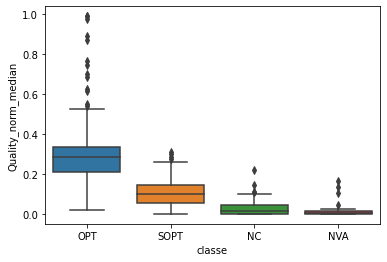

In [193]:
import seaborn as sns
sns.boxplot(data=train, y="Quality_norm_median", x="classe")

In [109]:
from statsmodels.stats.contingency_tables import cochrans_q
cochrans_q(resul[["pred_all", "pred_amplicon", "pred_tsv", "pred_Pearson", "pred_Spearman", "pred_rfe", "pred_rf"]])

ValueError: could not convert string to float: 'SOPT'

In [ ]:
print()

In [56]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators= 50)

feat = select_features("all")

clf.fit(train[feat], train["classe"])
pred = clf.predict(test[feat])

In [122]:
# fa = F1score(confusion_matrix(pre[pre["num"]==0]["classe"], pre[pre["num"]==0]["pred_all"], normalize="true", labels=["OPT", "NC", "SOPT", "NVA"]))

In [124]:
# pd.DataFrame(fa, index=["OPT", "NC", "SOPT", "NVA"], columns=["pred_all"])

,pred_all
OPT,0.933681
NC,0.915872
SOPT,0.894994
NVA,0.954545


analyse locale (déja faite)

In [17]:
#features importance for locale models
New_var1 = ['gc_percent', 'cov500_percent', 'fwd_e2e_percent', 'rev_e2e_percent', 'cov20_percent', 'cov100_percent', 'contig_length']

feat_impdt = pd.DataFrame(DT.feature_importances_, index=New_var1, columns=["feat_imp_DT"])
# feat_impdt = feat_impdt.sort_values(0)

feat_imprf = pd.DataFrame(RF.feature_importances_, index=New_var1, columns=["feat_imp_RF"])
# feat_imprf = feat_imprf.sort_values(0)

feat_imp = pd.concat([feat_impdt, feat_imprf], axis=1)
feat_imp

,feat_imp_DT,feat_imp_RF
gc_percent,0.025298,0.044892
cov500_percent,0.935296,0.584198
fwd_e2e_percent,0.007623,0.103293
rev_e2e_percent,0.011626,0.115837
cov20_percent,0.000252,0.011213
cov100_percent,0.007974,0.104602
contig_length,0.011931,0.035964
